<h1 style="text-align:center;font-size:40px;">Tools 1 Final Project</h1>
<br>
<br>
<br>
<br>
<br>
<p style="text-align:center;">Anthony Molieri<br>
Leo Walker</p>
<br>
<br>
<br>
<br>

# Dataset and Motivation

The data used for these analyses were scraped from Indeed and Glassdoor. The data from Indeed contains job descriptions for open Data Scientist positions. The Glassdoor data includes employee generated ratings on benefits and perks for many of the companies present in the Indeed dataset. The datasets were then combined in order to give an idea of how employees rank the benefits at these companies.

*The Indeed data was scraped over ... pulling job descriptions for Data Scientists in 25 cities throughout the US. **Leo** Add Correct Details, here about the Indded data and scraper*

The Glassdoor scraper was designed to pull company names from the the job description dataset. It then looped over the list of employers, searched, and scraped ratings from the benefits page for companies that were found. This data was then added to it's own table in the same database. The scraper was designed to be run multiple times, only searching for benefits ratings that were not already present in the database. 

# Task Definition and Research Question
 
The purpose of this project was to help give a better idea of how employees at companies with open positions rate their benefits. This can help give insight into how desirable a company is as an employer.

# Literature Review

*Add -- I'm not really sure what to add here. Maybe something about turnover in data science? Companies not having great benefits?*

# Data Cleaning

In [92]:
# imports
import numpy as np
import pandas as pd
import sqlite3
import re
import seaborn as sns



In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import seaborn as sns
import time

# nltk
import nltk
from nltk.corpus import stopwords
stoplist= stopwords.words('english')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer= WordNetLemmatizer()
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

# Enable logging
import logging
logging.basicConfig(level= logging.INFO)

# Importing gensim related libraries
import gensim
from gensim.models.ldamulticore import LdaMulticore
from gensim.corpora import Dictionary
from gensim.models import Phrases
from collections import Counter
from gensim.models import Word2Vec

In [94]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [95]:
# Initialize both tables
cnct = sqlite3.connect('Data/jobs')

indeed_df = pd.read_sql_query('SELECT * FROM indeed_jobs;', cnct)
indeed_df.drop('est salary', axis=1, inplace=True)

glassdoor_df = pd.read_sql_query('SELECT companies, type, rating, count_of_ratings FROM ratings;', cnct)

## Cleaning Indeed Data

In [96]:
# While we were able to get the estimated salary from the job scraping we can see if there was any job salaries within the job description
def salary_extract(row):
    if row['est_salary']!="No Estimated Salary":
        return row['est_salary']
    else:
        pattern = r"\$([0-9]{5,6}|[0-9]{2,3},[0-9]{3})"
        found = re.findall(pattern, row['job_desc'])
        if len(found)==1:
            return f'{found[0]} a year'
        elif len(found)>1:
            return f'{found[0]} - {found[1]} a year'
        else:
            return None

indeed_df['salary_extract'] = indeed_df.apply(salary_extract, axis=1)

In [97]:
# While we have the job title we need to categorize each job
def set_job_category(job_title):
    regex = re.compile('[^a-zA-Z]')
    clean_title = regex.sub('', job_title)
    clean_title = clean_title.lower()
    if all(x in clean_title for x in ["data", "scien"]):
        return "Data Scientist"
    elif all(x in clean_title for x in ["business", "analy"]):
        return "Business Intelligence Analyst"
    elif all(x in clean_title for x in ["bi", "analy"]):
        return "Business Intelligence Analyst"
    elif all(x in clean_title for x in ["data", "analy"]):
        return "Data Analyst"
    elif all(x in clean_title for x in ["machine", "learning"]):
        return "Machine Learning Engineer"
    elif all(x in clean_title for x in ["data", "engineer"]):
        return "Data Engineer"
    elif all(x in clean_title for x in ["software", "engin"]):
        return "Software Engineer"
    elif all(x in clean_title for x in ["architect"]):
        return "Data Architect"
    else:
        return "Other"

indeed_df['job_category'] = indeed_df.loc[:, 'job_title'].apply(set_job_category)

In [98]:
# Lets get the state from the company location so we can generalize them
indeed_df.loc[:,'state'] = indeed_df.loc[:, 'company_location'].str.extract(r', ([A-Z]{2})')

In [99]:
def salary_low(row):
    if row == None:
        return None
    salary = str(row).split('-')
    pattern = r'([0-9]+\.*,*[0-9]+)'
    low = float(''.join(re.findall(pattern, salary[0])).replace(',',''))
    return low

def salary_high(row):
    if row ==None:
        return None
    salary = str(row).split('-')
    pattern = r'([0-9]+\.*,*[0-9]+)'
    if len(salary)>1:
        high = float(''.join(re.findall(pattern, salary[1])).replace(',',''))
    else:
        high = float(''.join(re.findall(pattern, salary[0])).replace(',',''))
    return high

indeed_df['salary_low'] = indeed_df.loc[:,'salary_extract'].apply(salary_low)
indeed_df['salary_high'] = indeed_df.loc[:,'salary_extract'].apply(salary_high)

In [100]:
# We noticed that the pay rate varies between annual, month, week, day, or hour. 
def pay_rate(row):
    if row ==None:
        return None
    regex = re.compile('[.[0-9]]')
    clean_salary = regex.sub('', row)
    clean_salary = clean_salary.lower()
    if any(x in clean_salary for x in ["year"]):
        return "annual"
    elif any(x in clean_salary for x in ["month"]):
        return "month"
    elif any(x in clean_salary for x in ["week"]):
        return "week"
    elif any(x in clean_salary for x in ["day"]):
        return "day"
    elif any(x in clean_salary for x in ["hour"]):
        return "hour"
    else:
        return "Other"

indeed_df['pay_rate'] = indeed_df.loc[:, 'salary_extract'].apply(pay_rate)

In [101]:
def calc_salary(row):
    pay_rate=row['pay_rate']
    if (pay_rate == 'Other') or (pay_rate==None):
        return None

    rate_change= {'annual':1, 'month':12, 'week':52, 'day':260, 'hour':2080}
    est_annual_salary = ((row['salary_low']+row['salary_high'])/2)*rate_change[pay_rate]
    return est_annual_salary
indeed_df['est_annual_salary'] = indeed_df.loc[:,['salary_low','salary_high','pay_rate']].apply(calc_salary, axis=1)

In [102]:
indeed_df[indeed_df['est_salary']!='No Estimated Salary'].sample(4)

,index,job_title,company_name,company_location,job_href,job_desc,est_salary,retrieve_date,salary_extract,job_category,state,salary_low,salary_high,pay_rate,est_annual_salary
15322,4,"Manager, Data Science",DISH,"Denver, CO",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Department Summary DISH is a Fortune 200 c...,"$100,100 a year",2022-04-10,"$100,100 a year",Data Scientist,CO,100100.0,100100.0,annual,100100.0
11376,5,VP of Engineering,CyberCoders,"Remote in Austin, TX 78704",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,VP of Engineering Job Title: VP of Eng...,"$225,000 - $275,000 a year",2022-03-28,"$225,000 - $275,000 a year",Other,TX,225000.0,275000.0,annual,250000.0
11134,11,Entry Level Business Analyst,PCS GLOBAL TECH,"Austin, TX",https://www.indeed.com/company/PCS-GLOBAL-TECH...,Entry Level Business Analyst Responsibilities...,"$65,000 - $70,000 a year",2022-03-28,"$65,000 - $70,000 a year",Business Intelligence Analyst,TX,65000.0,70000.0,annual,67500.0
11600,9,"Business Intelligence Architect, Customer Anal...",Salesforce,"San Francisco, CA 94105 (Financial District/So...",https://www.indeed.com/rc/clk?jk=ded5a8e0fa3ca...,"To get the best candidate experience, please...","$128,600 a year",2022-03-28,"$128,600 a year",Business Intelligence Analyst,CA,128600.0,128600.0,annual,128600.0


# Visualizations

Lets start by looking at average salary by state and job category

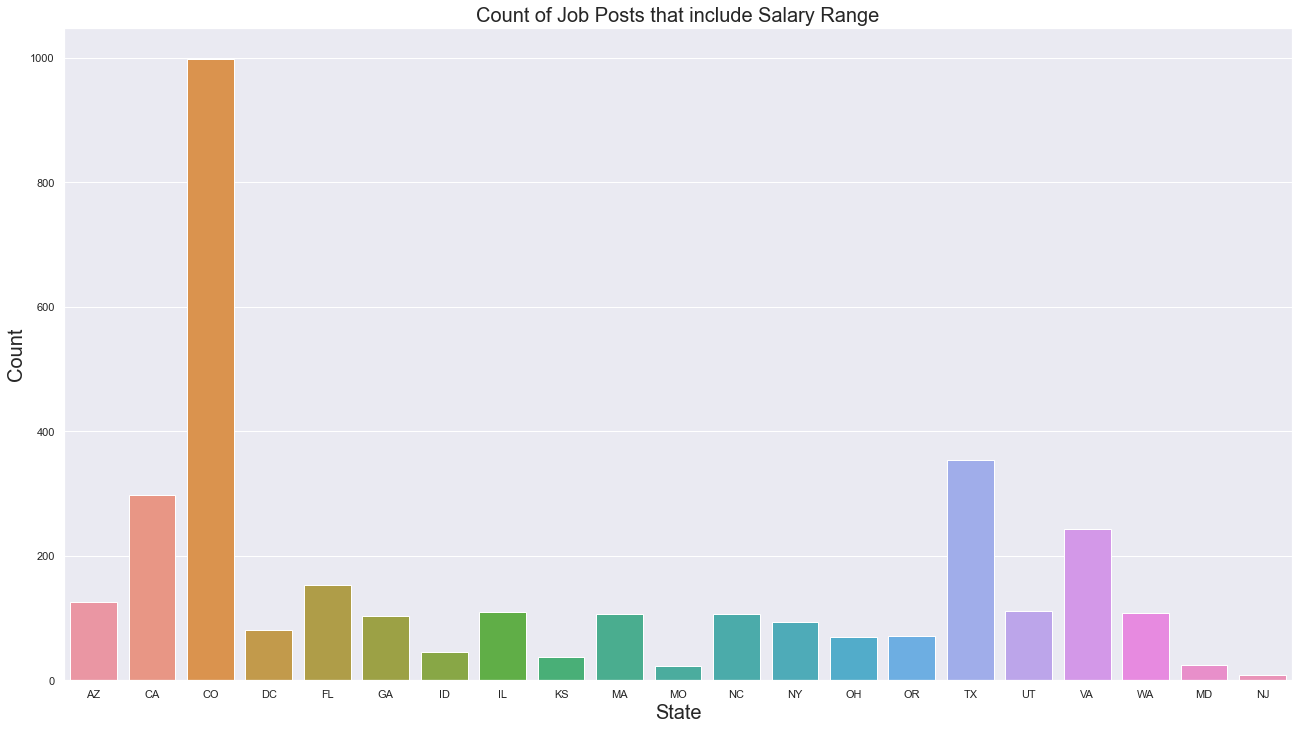

In [189]:
# Lets see what states share their salary the most
salary_by_job_state_count = indeed_df[((indeed_df['job_category']!='Other')&(indeed_df['est_annual_salary']>0))].groupby(['job_category', 'state'])['est_annual_salary'].count().reset_index()
sns.set(rc={'figure.figsize':(22,12)})
ax = sns.barplot(x='state', y='est_annual_salary', data=salary_by_job_state_count, estimator=sum,ci=None)
plt.title('Count of Job Posts that include Salary Range',fontsize = 20)
plt.xlabel("State",fontsize=20)
plt.ylabel("Count",fontsize=20)
plt.savefig('Images/Count_of_Job_Posts_that_include_Salary_Range.png')

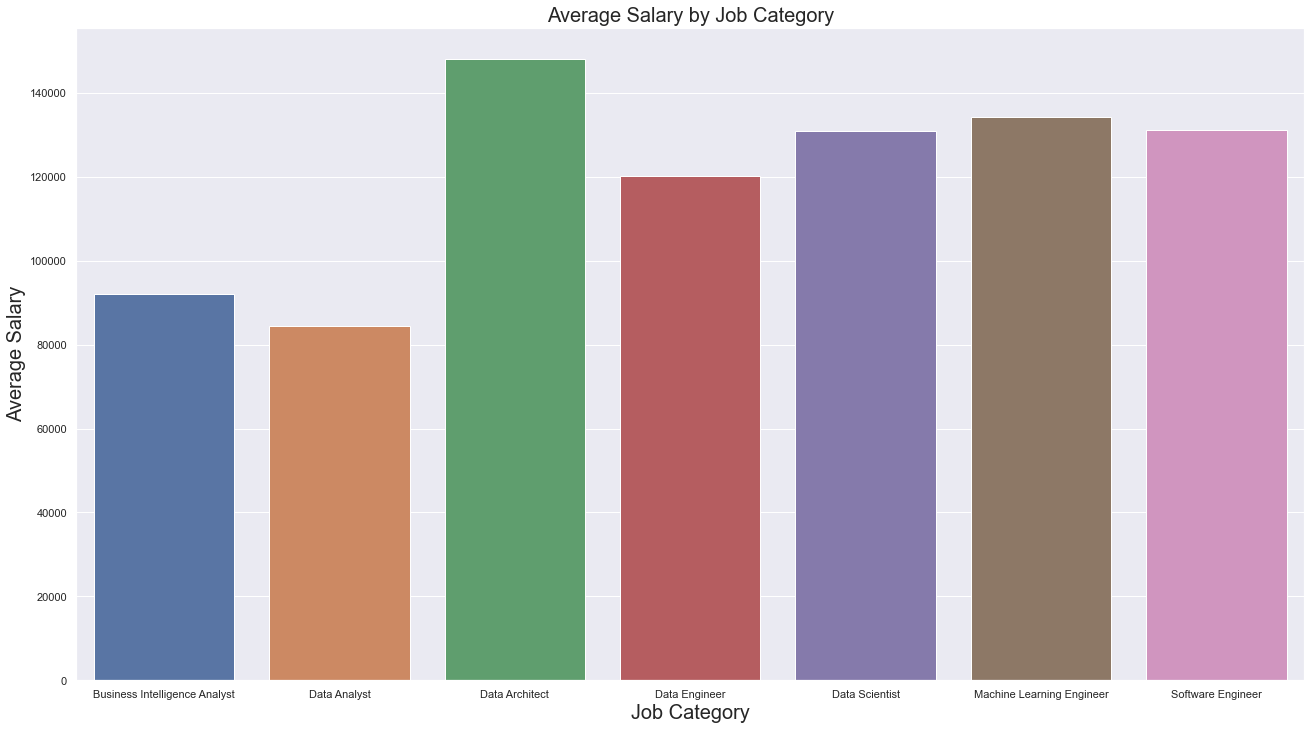

In [190]:
salary_by_job_state_mean = indeed_df[((indeed_df['job_category']!='Other')&(indeed_df['est_annual_salary']>0))].groupby(['job_category'])['est_annual_salary'].mean().reset_index()
sns.set(rc={'figure.figsize':(22,12)})
ax = sns.barplot(x='job_category', y='est_annual_salary', data=salary_by_job_state_mean)
plt.title('Average Salary by Job Category',fontsize = 20)
plt.xlabel("Job Category",fontsize=20)
plt.ylabel("Average Salary",fontsize=20)
plt.savefig('Images/Average_Salary_by_Job_Category.png')

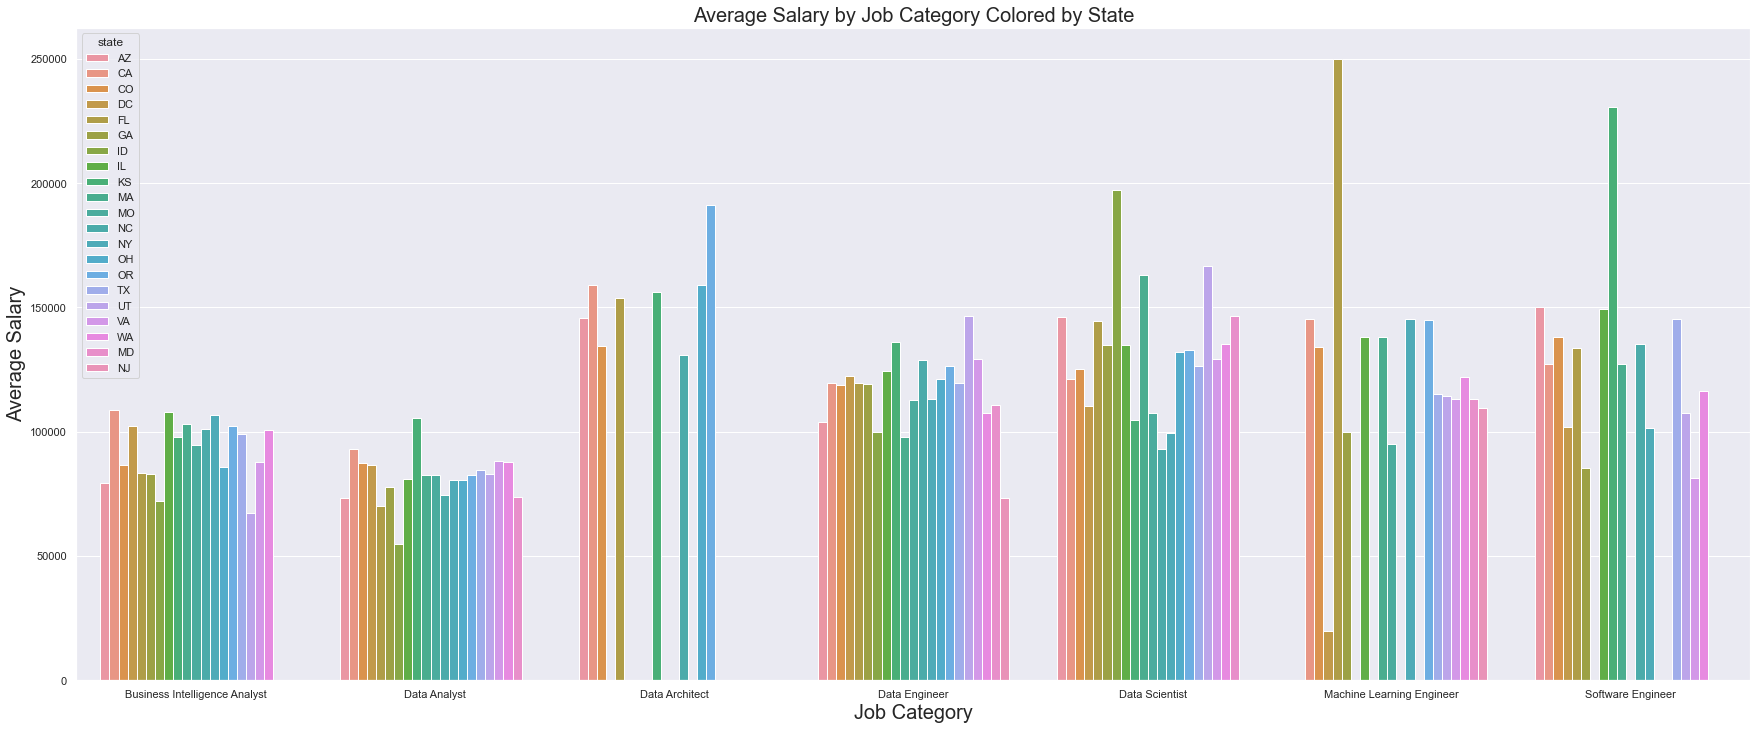

In [191]:
salary_by_job_state_mean = indeed_df[((indeed_df['job_category']!='Other')&(indeed_df['est_annual_salary']>0))].groupby(['job_category', 'state'])['est_annual_salary'].mean().reset_index()
sns.set(rc={'figure.figsize':(30,12)})
ax = sns.barplot(x='job_category', y='est_annual_salary', hue='state', data=salary_by_job_state_mean)
plt.title('Average Salary by Job Category Colored by State',fontsize = 20)
plt.xlabel("Job Category",fontsize=20)
plt.ylabel("Average Salary",fontsize=20)
plt.savefig('Images/Average_Salary_by_Job_Category_by_State.png')

### Natural Language Processing (NLP)

In [106]:
indeed_df.dropna(subset=['job_desc'], inplace=True)

In [174]:
# Taking a sample of the indeed_df of the initial job cetegories that we were interested in
sample_df = indeed_df[indeed_df.job_category.isin(['Data Scientist', 'Data Analyst', 'Machine Learning Engineer', 'Data Engineer','Business Intelligence Analyst', 'Data Architect'])].copy()

In [175]:
stoplist = ["year", "experience", "opportunity", "employer", "sexual", "orientation", "national", "origin"\
        "veteran", "status", "work", "race", "color", "religion", "orientation", "gender", "regard", "this", "position"\
        "related", "field", "closely", "with", "disability", "federal", "state", "local", "more", "than",\
        "receive", "equal", "opportunity", "veteran", "protect", "employment", "consideration", "accommodation",\
        "role", "employee", "benefit", "applicant", "such","what", "their", "company", "understand", "their", "about",\
        "what", "minimum", "please", "which", "and/or", "vaccine", "vaccination"] \
    + [word.lower() for company in indeed_df.company_name.unique() for word in company]


In [176]:
def get_pos_tag(tag):
    """This function is used to get the part-of-speech(POS) for lemmatization"""
    
    if tag.startswith('N') or tag.startswith('J'):
        return wordnet.NOUN
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN #default case

In [177]:
def preprocess(text):
    """ 1. Removes Punctuations
        2. Removes words smaller than 3 letters
        3. Converts into lowercase
        4. Lemmatizes words
        5. Removes Stopwords
    """   
    punctuation= list(string.punctuation)
    doc_tokens= nltk.word_tokenize(text)
    word_tokens= [word.lower() for word in doc_tokens if not (word in punctuation or len(word)<=3)]
    
    # Lemmatize    
    pos_tags=nltk.pos_tag(word_tokens)
#     print(pos_tags)
    doc_words=[wordnet_lemmatizer.lemmatize(word, pos=get_pos_tag(tag)) for word, tag in pos_tags]
    doc_words= [word for word in doc_words if word not in stoplist]
    stemmer=nltk.stem.PorterStemmer()
    doc_words=[stemmer.stem(word) for word in doc_words]
    
    
    return doc_words

job_desc_df_clean = sample_df['job_desc'].apply(preprocess)

In [159]:
docs= list(job_desc_df_clean)
phrases = gensim.models.Phrases(docs, min_count=10, threshold=20)
bigram_model = gensim.models.phrases.Phraser(phrases)

In [153]:
def make_bigrams(texts):
    return [bigram_model[doc] for doc in texts]

# Form Bigrams
data_words_bigrams = make_bigrams(docs)

In [154]:
# Checkout most frequent bigrams :
bigram_counter1= Counter()
for key in phrases.vocab.keys():
    if key not in stoplist:
        if len(str(key).split('_'))>1:
            bigram_counter1[key]+=phrases.vocab[key]

for key, counts in bigram_counter1.most_common(15):
    print(key,">>>>", counts)

machin_learn >>>> 100
thi_posit >>>> 66
opportun_employ >>>> 58
data_scienc >>>> 56
bachelor_degre >>>> 54
nation_origin >>>> 54
data_analyt >>>> 53
comput_scienc >>>> 50
data_engin >>>> 49
experi_data >>>> 44
reason_accommod >>>> 43
data_analysi >>>> 42
data_scientist >>>> 40
commun_skill >>>> 37
qualifi_applic >>>> 35


In [160]:
dictionary= Dictionary(data_words_bigrams)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.6)
corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 313
Number of documents: 100


In [169]:
from gensim.models.ldamulticore import LdaMulticore

t0= time.time()
passes= 30
np.random.seed(1) # setting up random seed to get the same results
ldamodel= LdaMulticore(corpus, 
                    id2word=dictionary, 
                    num_topics=6, 
#                   alpha='asymmetric', 
                    chunksize= 4000, 
                    batch= True,
                    minimum_probability=0.001,
                    iterations=350,
                    passes=passes)                    

t1= time.time()
print("time for",passes," passes: ",(t1-t0)," seconds")

time for 30  passes:  10.26112174987793  seconds


In [170]:
ldamodel.show_topics(num_words=15, formatted=False)

[(4,
  [('what', 0.041599475),
   ('time', 0.033366665),
   ('full', 0.020014191),
   ('famili', 0.018873286),
   ('custom', 0.018043986),
   ('plan', 0.01703008),
   ('like', 0.016843226),
   ('report', 0.016303787),
   ('medic', 0.015833268),
   ('locat', 0.015774002),
   ('partner', 0.015464217),
   ('present', 0.01541584),
   ('within', 0.01530545),
   ('technic', 0.015277169),
   ('expect', 0.014779071)]),
 (1,
  [('custom', 0.019881202),
   ('compani', 0.017780771),
   ('drive', 0.017367736),
   ('scienc', 0.016997235),
   ('learn', 0.016541211),
   ('problem', 0.015555314),
   ('market', 0.014742924),
   ('understand', 0.014646271),
   ('partner', 0.014353361),
   ('about', 0.014184326),
   ('creat', 0.013319558),
   ('help', 0.013159476),
   ('stakehold', 0.012677776),
   ('across', 0.012517729),
   ('model', 0.012229694)]),
 (0,
  [('learn', 0.025094746),
   ('softwar', 0.023499925),
   ('custom', 0.012329755),
   ('compani', 0.011729623),
   ('base', 0.010953378),
   ('techni

In [171]:
lda_corpus= ldamodel[corpus]

In [172]:
import pyLDAvis
import pyLDAvis.gensim_models

In [173]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.005763  0.019954       1        1  18.819199
8      0.045001 -0.017021       2        1  14.451098
7     -0.018366 -0.000227       3        1  14.359406
1     -0.059074 -0.027184       4        1  13.856719
10     0.023990 -0.139062       5        1  12.236257
9      0.022147  0.019847       6        1   8.152814
5      0.080355  0.145308       7        1   6.191470
3     -0.058047 -0.145002       8        1   3.330321
4     -0.022386 -0.024270       9        1   3.052491
6     -0.267799  0.105376      10        1   2.224602
11     0.150105  0.072258      11        1   1.677566
2      0.109837 -0.009976      12        1   1.648057, topic_info=          Term        Freq       Total Category  logprob  loglift
48       model  174.000000  174.000000  Default  30.0000  30.0000
110     custom  132.000000  132.000000  Default  29.0000  29.0000
154    softwar  117.000000  117.000000  Default  28.0000  28.0000
193       lead   89.000000   89.000000  Default  27.0000  27.0000
249      learn  195.000000  195.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
155       solv    2.859070   74.331063  Topic12  -4.5367   0.8475
151    problem    3.411682  114.759527  Topic12  -4.3600   0.5899
192   knowledg    3.245143  119.403705  Topic12  -4.4100   0.5002
106    complex    2.649034   74.334787  Topic12  -4.6130   0.7712
38   implement    2.810664   94.467965  Topic12  -4.5538   0.5907

[583 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
292       2  0.109959    abl
292       3  0.256570    abl
292       4  0.403181    abl
292       5  0.073306    abl
292       6  0.036653    abl
...     ...       ...    ...
226       4  0.143156  write
226       5  0.157471  write
226       7  0.057262  write
226       8  0.028631  write
226      12  0.014316  write

[1957 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 9, 8, 2, 11, 10, 6, 4, 5, 7, 12, 3])

Below is some tests from a previous project, It doesn't interpret very well so I think I'll drop it but it also took a while to run so keeping it for now

In [ ]:
# from sklearn.decomposition import NMF
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# %matplotlib inline

# import nlp_processing

In [119]:
# corpus = list(indeed_df['job_desc'])
# clean_corpus = [nlp_processing.process_string(doc) for doc in corpus]

In [123]:
# np.random.seed(12345)
# working_corpus = clean_corpus.copy()
# vectorizer, vocabulary = nlp_processing.build_text_vectorizer(working_corpus,
#                              use_tfidf=True,
#                              max_features=2000)
# word_mat = vectorizer(working_corpus)

# # Find latent topics using our NMF model.
# factorizer = NMF(n_components=7, alpha=0.5, l1_ratio=0.1, verbose=0)
# W = factorizer.fit_transform(word_mat)
# H = factorizer.components_

c:\Users\leowa\anaconda3\envs\JobsNLP\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\leowa\anaconda3\envs\JobsNLP\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
c:\Users\leowa\anaconda3\envs\JobsNLP\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [124]:
# for i, row in enumerate(H):
#         num_words = np.argsort(row)[::-1][:50]
#         print ('Topic', i)
#         print (' '.join(vocabulary[num_words]), '\n')

Topic 0
project process management information analyst application program analysis development ensure need plan user knowledge technical department perform develop technology issue andor procedure assist documentation manage financial meet communication maintain improvement analyze duty level design research policy identify activity review standard functional lead organization strong staff test relate quality assign function 

Topic 1
machine learning engineer software engineering technology ml design science cloud model development platform learn aws datum amazon pipeline code scientist algorithm technical computer ai python develop architecture infrastructure scale security language application production deep problem vmware deploy feature java programming azure framework lead test spark processing scalable tool solve large 

Topic 2
accenture accommodation disclose compensation observance colorado authorization cloud information investigation recruiting reasonable minimum continue 

In [125]:
# labels = W.argmax(axis=1)
# for i in range(0, W.shape[1]):
#     print ("Topic {} contains {} documents.".format(i, np.sum(labels == i)))

Topic 0 contains 5998 documents.
Topic 1 contains 5022 documents.
Topic 2 contains 310 documents.
Topic 3 contains 4961 documents.
Topic 4 contains 318 documents.
Topic 5 contains 336 documents.
Topic 6 contains 241 documents.


In [132]:
# indeed_df.job_category.unique()
# label_dict = {'Data Scientist':0, 'Machine Learning Engineer': 2, 'Data Analyst':3, 'Business Intelligence Analyst':4,
#          'Data Engineer':5, 'Data Architect':6, 'Software Engineer':7,'Other':8}
        

In [135]:
# indeed_df['num_labels'] = indeed_df['job_category'].map(label_dict)
# real_labels = indeed_df['num_labels'].ravel()

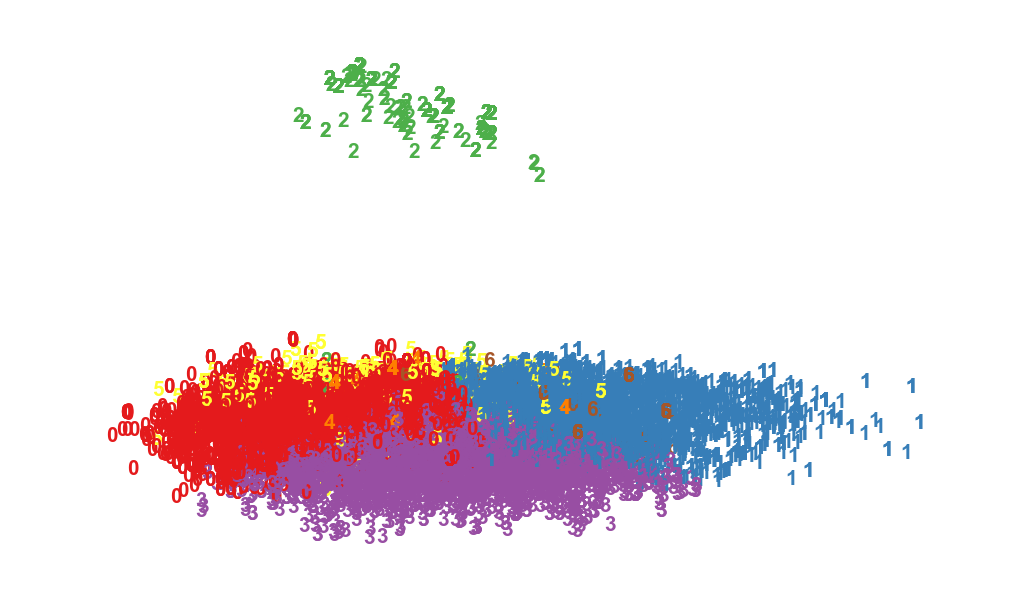

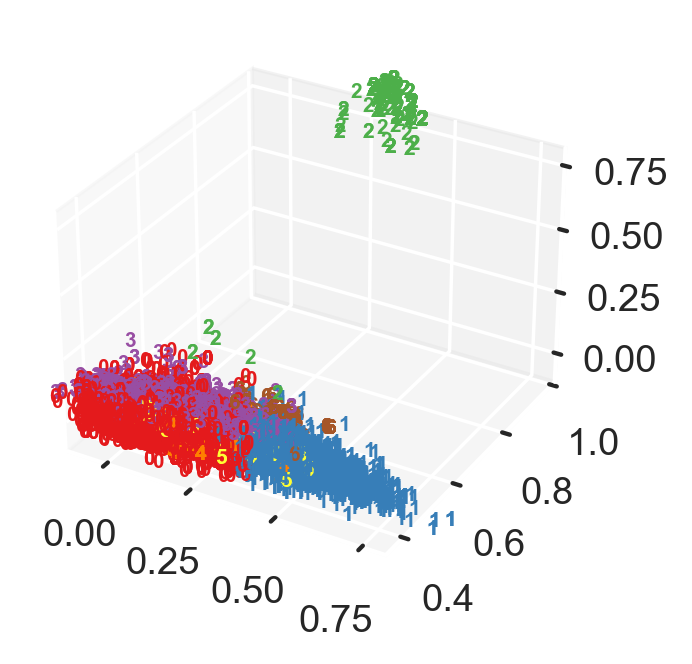

In [140]:
# 